# **LLaMA 2 fine-tuning with dataset**

*Andrés Herencia López-Menchero*

**MUTECI 2023/2024**

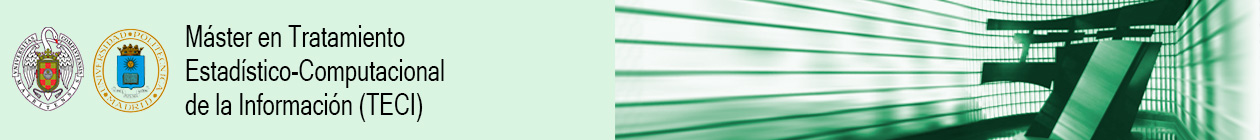

## Pre-requisites

### Install necessary libraries

In [1]:
!pip install -q accelerate==0.21.0 \
                peft==0.4.0 \
                bitsandbytes==0.40.2 \
                transformers==4.31.0 \
                trl==0.4.7 \
                rouge_score \
                bert_score \
                huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/

### Import modules

In [2]:
import os
import torch
import pandas as pd
from datasets import load_dataset, load_metric
from accelerate import Accelerator
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    TrainerCallback,
    TrainerState,
    TrainerControl,
    pipeline,
    logging,
)
from huggingface_hub import HfApi, HfFolder, notebook_login
from getpass import getpass
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
from torch.utils.tensorboard import SummaryWriter

/usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


### Google Drive connection

In [4]:
from google.colab import drive, userdata
drive.mount('/content/drive')
token = userdata.get('HF_TOKEN')

ValueError: mount failed

In [ ]:
notebook_login()

### Path definitions

In [5]:
output_path = '/content/drive/MyDrive/TFM/results'
global_path = '/content/drive/MyDrive/TFM'
fine_tuned_model_path = f"{output_path}/model"
tokenizer_path = f'{fine_tuned_model_path}/tokenizer'

## Model definition

In [6]:
# The model that you want to train from the Hugging Face hub
model_name = "meta-llama/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "andreshere/counsel_chat"

# Fine-tuned model name
new_model = "llama-2-7b-mental-health-counseler"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = output_path

# Number of training epochs
num_train_epochs = 5

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 2

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

## Machine Learning pipeline

In [7]:
train_dataset = load_dataset(dataset_name, split="train")
test_dataset = load_dataset(dataset_name, split="test")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map,
    use_auth_token=token
)

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
    use_auth_token=token
)

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=f'{output_path}/runs',  # Ensure this directory is accessible and correct
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Define compute_metrics function
rouge = load_metric('rouge')
bert_score = load_metric('bertscore')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    rouge_output = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    bert_score_output = bert_score.compute(predictions=decoded_preds, references=decoded_labels, lang='en')
    return {"rouge": rouge_output, "bert_score": bert_score_output}

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    dataset_text_field="Context",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    compute_metrics=compute_metrics,
    packing=packing,
)

# Train model
trainer.train()

# Save trained model

trainer.model.save_pretrained(fine_tuned_model_path)
trainer.save_model(fine_tuned_model_path)
tokenizer.save_pretrained(f"{fine_tuned_model_path}/tokenizer")

### Upload model

In [8]:
trainer.save_model("./llama-2-7b-mental-health-counseler")

In [10]:
trainer.push_to_hub("andreshere/llama-2-7b-mental-health-counseler")

### Evaluate the model

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(f"{fine_tuned_model_path}/tokenizer")

# Load configuration and then model
from transformers import AutoConfig

config = AutoConfig.from_pretrained(f"{fine_tuned_model_path}")
model = AutoModelForCausalLM.from_pretrained(
    f"{fine_tuned_model_path}/model",
    config=config
)
model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Set evaluation parameters
training_arguments = TrainingArguments(
    output_dir=f'{output_path}/runs',  # Ensure this directory is accessible and correct
    per_device_eval_batch_size=1,      # Small batch size for evaluation to avoid OOM errors
)

# Define compute_metrics function
rouge = load_metric('rouge')
bert_score = load_metric('bertscore')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    rouge_output = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    bert_score_output = bert_score.compute(predictions=decoded_preds, references=decoded_labels, lang='en')
    return {"rouge": rouge_output, "bert_score": bert_score_output}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_arguments,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
# Evaluate the model on the test dataset
eval_results = trainer.evaluate()

# Save evaluation results
eval_results_path = f"{output_path}/evaluation_results.csv"
pd.DataFrame([eval_results]).to_csv(eval_results_path, index=False)
print(f"Evaluation results saved to {eval_results_path}")


### Generate responses over the test set

In [ ]:
def generate_and_save_responses(model, tokenizer, dataset_name, output_path):
    # Load the test dataset
    test_dataset = load_dataset(dataset_name, split='test')

    # Ensure the model is in evaluation mode
    model.eval()

    generated_responses = []

    for row in test_dataset:
        context = row['Context']
        try:
            inputs = tokenizer(context, return_tensors="pt").to(model.device)
            outputs = model.generate(inputs['input_ids'], max_length=50)
            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            generated_responses.append({"Context": context, "Response": generated_text})
        except RuntimeError as e:
            print(f"Error generating response for context: {context}\nError: {e}")
            generated_responses.append({"Context": context, "Response": "Error generating response"})

    # Create a DataFrame
    df = pd.DataFrame(generated_responses)

    # Get current date and time for the filename
    date_hour = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"{output_path}/data/responses_{date_hour}.csv"

    # Ensure the output directory exists
    os.makedirs(f"{output_path}/data", exist_ok=True)

    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=False)

    print(f"Responses saved to {output_file}")

# Example usage:
dataset_name = "andreshere/counsel_chat"
generate_and_save_responses(model, tokenizer, dataset_name, output_path)

In [ ]:
generate_and_save_responses(fine_tuned_model_path, tokenizer_path, dataset_name, output_path)

### Visualizing metrics using Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/TFM/results/runs

In [ ]:
dataset[2]

## Model inference

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "I feel like my life does not have sense anymore. What can I do?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer)
#result = pipe(f"<s>[INST] {prompt} [/INST]")
result = pipe(f"{prompt}")
print(result[0]['generated_text'])

## Cleaning workspace and reload model

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          trust_remote_code=True,
                                          use_auth_token=token)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"